In [ ]:
import pandas as pd
import ast  # Pour convertir une chaîne représentant une liste en liste

# Charger uniquement les colonnes nécessaires
cols_to_load = ['liste_libelle_risque', 'libelle_commune']
data = pd.read_csv('flood_risk_data.csv')

# Convertir la colonne `liste_libelle_risque` en une liste de dictionnaires
data['liste_libelle_risque'] = data['liste_libelle_risque'].apply(ast.literal_eval)

# Séparer les éléments des dictionnaires en colonnes distinctes
expanded_data = data.explode('liste_libelle_risque')  # Sépare chaque élément de la liste dans une nouvelle ligne
expanded_data[['num_risque', 'libelle_risque_long']] = expanded_data['liste_libelle_risque'].apply(pd.Series)

# Supprimer la colonne d'origine après extraction
expanded_data = expanded_data.drop(columns=['liste_libelle_risque'])

# Afficher les premières lignes du DataFrame transformé
expanded_data.head()

,code_national_tri,libelle_tri,libelle_bassin_risques,date_arrete_pcb,date_arrete_carte,date_arrete_pcb_local,date_arrete_prefet_parties_prenantes,date_arrete_approbation,date_arrete_national,code_insee,libelle_commune,num_risque,libelle_risque_long
0,01DREAL20160001,Lyon,NaN,12/12/2012,20/12/2013,15/02/2016,NaN,NaN,06/11/2012,01030,BEAUREGARD,180,Par une crue à débordement lent de cours d'eau
0,01DREAL20160001,Lyon,NaN,12/12/2012,20/12/2013,15/02/2016,NaN,NaN,06/11/2012,01030,BEAUREGARD,183,Par une crue torrentielle ou à montée rapide d...
1,01DREAL20160001,Lyon,NaN,12/12/2012,20/12/2013,15/02/2016,NaN,NaN,06/11/2012,01043,BEYNOST,180,Par une crue à débordement lent de cours d'eau
1,01DREAL20160001,Lyon,NaN,12/12/2012,20/12/2013,15/02/2016,NaN,NaN,06/11/2012,01043,BEYNOST,183,Par une crue torrentielle ou à montée rapide d...
2,71DREAL20140002,TRI du Mâconnais,RMC,12/12/2012,20/12/2013,15/02/2016,04/03/2016,21/12/2016,27/04/2012,01123,CORMORANCHE-SUR-SAONE,180,Par une crue à débordement lent de cours d'eau


In [3]:
#conserver en format csv la dataFrame transformée 
expanded_data.to_csv("Type_inondation_data.csv", index=False)

In [3]:
from cartiflette import carti_download

france = carti_download(
    values=["France"],
    crs=4326,
    borders="COMMUNE",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)
france = france.loc[france["INSEE_REG"] > 10]

This is an experimental version of cartiflette published on PyPi.
To use the latest stable version, you can install it directly from GitHub with the following command:
pip install git+https://github.com/inseeFrLab/cartiflette.git


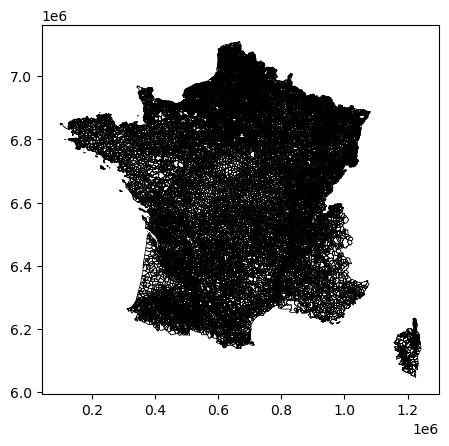

In [4]:
france_2154 = france.to_crs(2154)
ax1 = france_2154.boundary.plot(edgecolor="k", linewidth=0.5)


/tmp/ipykernel_261636/1026648894.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


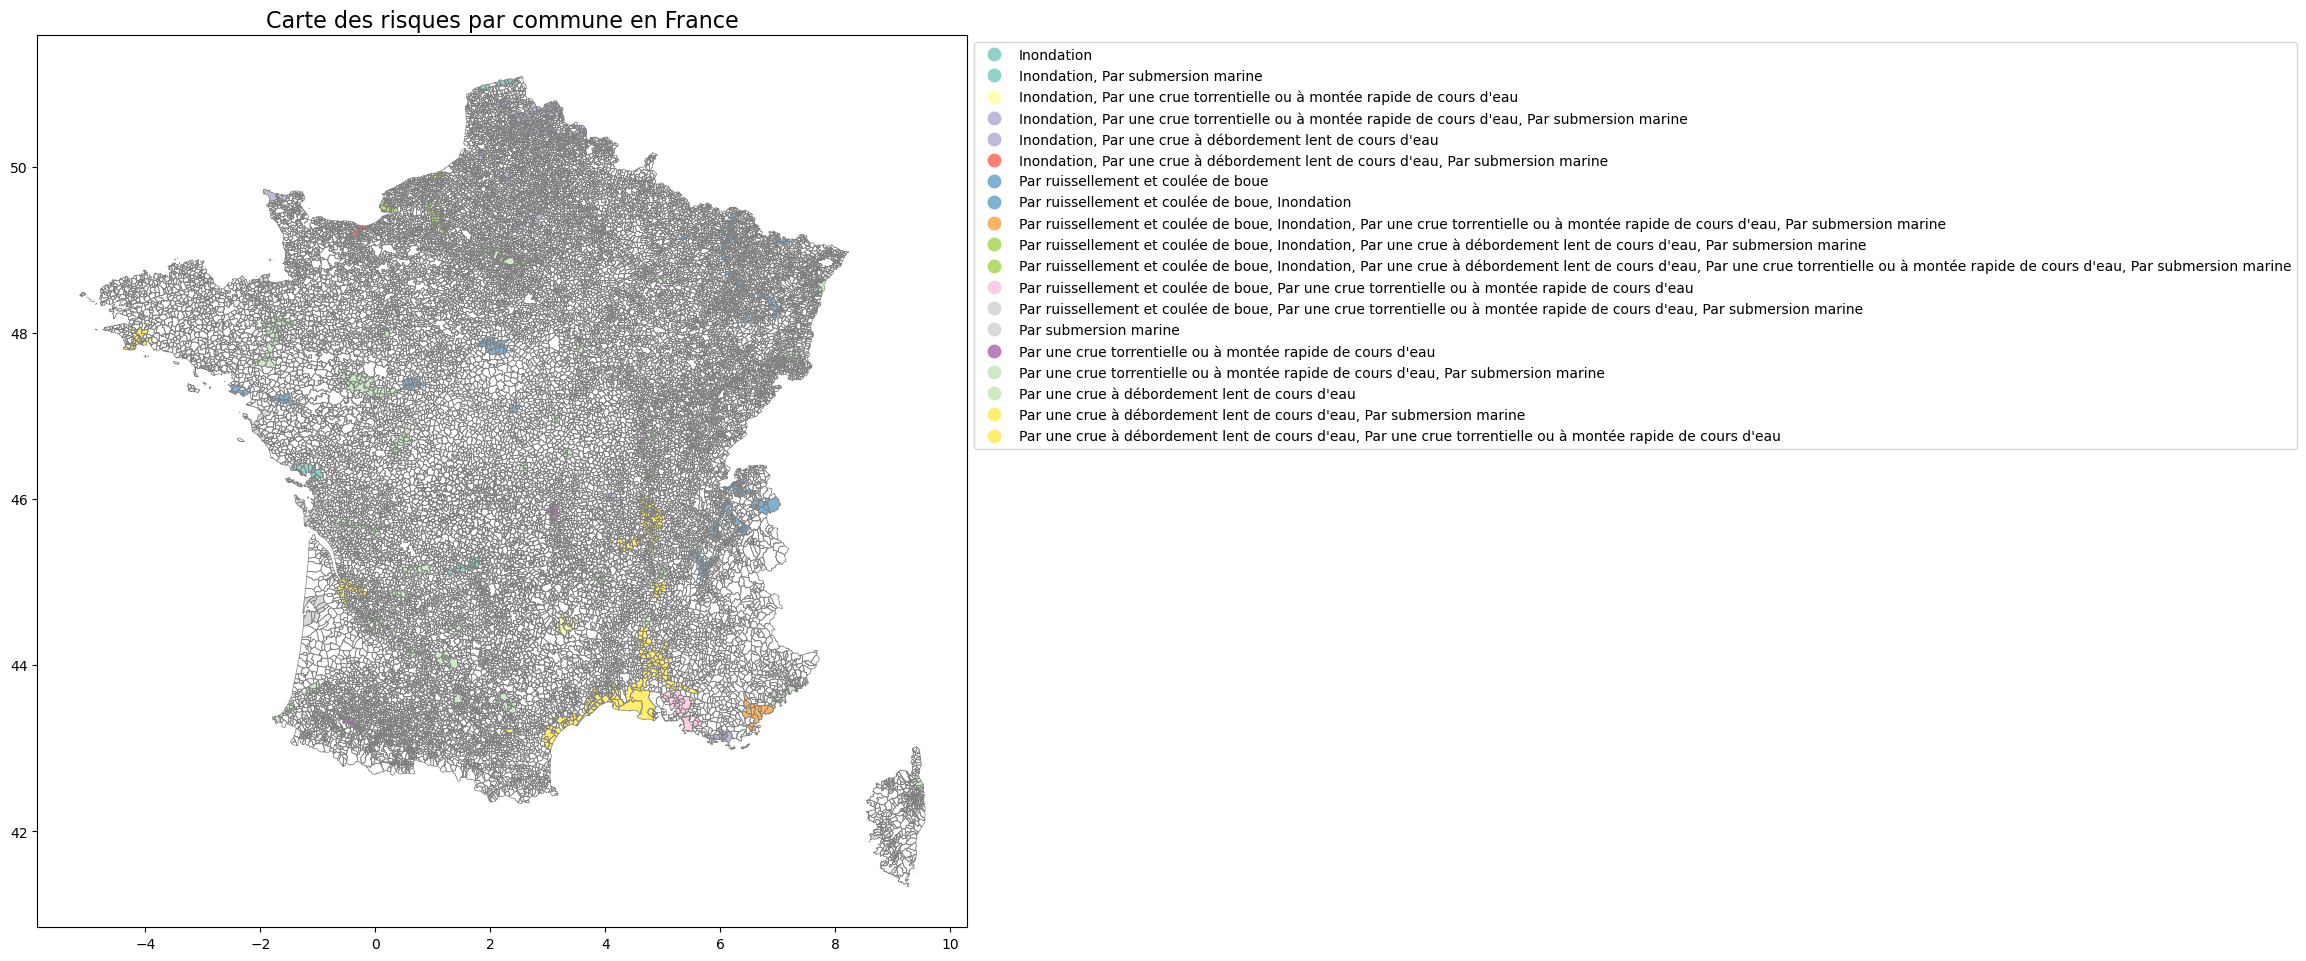

In [5]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from cartiflette import carti_download

#Télécharger les données géographiques des communes françaises via Cartiflette
france = carti_download(
    values=["France"],
    crs=4326,
    borders="COMMUNE",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

#Filtrer pour ne garder que les communes métropolitaines
france = france.loc[france["INSEE_REG"] > 10]

#Charger les données de risques transformées et associer les risques multiples à chaque commune
risk_data_grouped = expanded_data.groupby('code_insee')['libelle_risque_long'].apply(
    lambda x: ', '.join(x.unique())
).reset_index()

#Fusionner les données géographiques avec les risques
geo_risks = france.merge(risk_data_grouped, left_on='INSEE_COM', right_on='code_insee', how='left')

# 4. Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(12, 15))

# Afficher les limites des communes
france.boundary.plot(ax=ax, linewidth=0.5, color="gray")

# Remplir les communes avec des couleurs basées sur les risques
geo_risks.plot(
    column='libelle_risque_long',  # Colonne contenant les types de risques
    ax=ax,
    legend=True,
    cmap="Set3",  # Palette de couleurs pour différencier les risques
    legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
)

# Ajouter un titre et améliorer la mise en page
plt.title("Carte des risques par commune en France", fontsize=16)
plt.tight_layout()

# Afficher la carte
plt.show()
